In [1]:
import os
import torch
import torchvision
from torchvision.utils import make_grid
from torch import nn
import numpy as np
import pandas as pd
import random


%matplotlib inline
import matplotlib.pyplot as plt

Set Seed for Reporduciblity

In [2]:
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Randome Noise for Image Size

In [3]:


image_col = 28
image_row = 28

n_channels= 1

img_shape = (image_row,image_col,n_channels)

z_dim =100 # No of Images

In [4]:


batch_size = 64

images_to_diplay = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [5]:
train =  torchvision.datasets.MNIST('datasets',
                           train=True,
                           download=True,
                           transform=torchvision.transforms.ToTensor())

test =  torchvision.datasets.MNIST('datasets',
                           train=False,
                           download=True,
                           transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,
                                           shuffle =True,
                                           num_workers=6,
                                           pin_memory =True)


test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,
                                           shuffle =False,
                                           num_workers=6,
                                           pin_memory =True)

In [6]:
# image_batch[0].shape

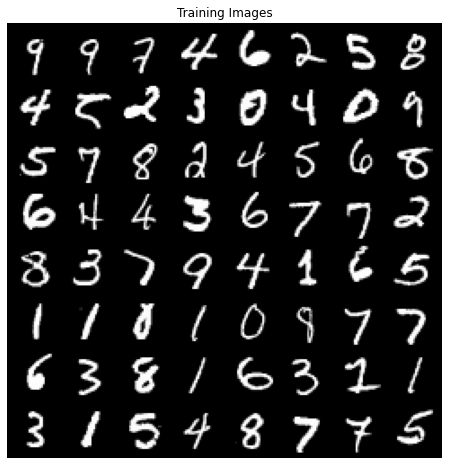

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() ) else "cpu")
image_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(image_batch[0].to(device)[:images_to_diplay], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


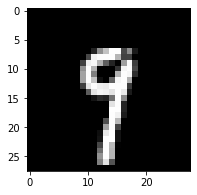

In [8]:
images = image_batch[0].numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self,input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        self.generator_nn = nn.Sequential(
            nn.Linear(input_size,hidden_dim*4),
            nn.LeakyReLU(negative_slope=0.01,inplace=True),
            # nn.Dropout(0.3,inplace=True),
            # nn.Linear(hidden_dim,hidden_dim*2),
            # nn.LeakyReLU(negative_slope=0.1,inplace=False),
            # nn.Dropout(0.3,inplace=True),
            # nn.Linear(hidden_dim*2,hidden_dim*4),
            # nn.LeakyReLU(negative_slope=0.1,inplace=False),
            # nn.Dropout(0.3,inplace=True),
            nn.Linear(hidden_dim*4,output_size),
            nn.Tanh()        )

          

    def forward(self, input):
        return self.generator_nn(input)

In [11]:
class Discriminator(nn.Module):
    def __init__(self,input_size,hidden_dim,output_size):
        super(Discriminator, self).__init__()
        self.discriminator_nn = nn.Sequential(
            nn.Linear(input_size,hidden_dim),
            nn.LeakyReLU(negative_slope=0.01,inplace=True),
            # nn.Dropout(0.3,inplace=True),

            # nn.Linear(hidden_dim*4,hidden_dim*2),
            # nn.LeakyReLU(negative_slope=0.1,inplace=False),
            # nn.Dropout(0.3,inplace=True),

            # nn.Linear(hidden_dim*2,hidden_dim),
            # nn.LeakyReLU(negative_slope=0.1,inplace=False),
            # nn.Dropout(0.3,inplace=True),

            nn.Linear(hidden_dim,output_size),
            nn.Sigmoid()
            )



    def forward(self, input):
      input=input.view(-1,28*28)
      return self.discriminator_nn(input)

In [12]:
#Discriminator HyperParams

input_size = 784

d_output_size = 1

d_hidden_size = 64

# Generator hyperparams

z_size = 100

g_output_size = 784

g_hidden_size = 64



D = Discriminator(input_size, d_hidden_size, d_output_size).to(device)
D.apply(weights_init)


G = Generator(z_size, g_hidden_size, g_output_size).to(device)
G.apply(weights_init)



print(D)
print()
print(G)

Discriminator(
  (discriminator_nn): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

Generator(
  (generator_nn): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Tanh()
  )
)


In [13]:
image_tot =1
for i in img_shape:
  image_tot = image_tot*i
image_tot

784

In [14]:
# netG = Generator(z_dim,image_tot).to(device)

# netG.apply(weights_init)

# # Print the model
# print(netG)

In [15]:
# netD = Discriminator(image_tot,1).to(device)

# netD.apply(weights_init)

# # Print the model
# print(netD)

In [16]:
torch.randn(batch_size, z_dim, 1, 1, device=device).shape

torch.Size([64, 100, 1, 1])

In [17]:
# Initialize Loss function
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# # Setup Adam optimizers for both G and D
# optimizerD = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerG = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

optimizerD = torch.optim.Adam(D.parameters(), lr=lr)
optimizerG = torch.optim.Adam(G.parameters(), lr=lr)

In [18]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        D.zero_grad()
        real_cpu = data[0].to(device)

        real_cpu = real_cpu*2 - 1
        
        b_size = real_cpu.size(0)
        
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        real_cpu = real_cpu.reshape(b_size,-1)
        
        output = D(real_cpu).view(-1)

        errD_real = criterion(output, label)
        
        
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        # Generate fake image batch with G
        noise = noise.reshape(b_size,-1)
        fake = G(noise)
        # print(fake.shape)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fixed_noise = fixed_noise.reshape(batch_size,-1)
                fake = G(fixed_noise).detach().cpu().reshape(batch_size,1,28,28)
            img_list.append(make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/938]	Loss_D: 1.3086	Loss_G: 0.7275	D(x): 0.5392	D(G(z)): 0.4985 / 0.4832
[0/50][50/938]	Loss_D: 0.2400	Loss_G: 2.5555	D(x): 0.9833	D(G(z)): 0.1986 / 0.0817
[0/50][100/938]	Loss_D: 0.2162	Loss_G: 3.2392	D(x): 0.8911	D(G(z)): 0.0933 / 0.0441
[0/50][150/938]	Loss_D: 0.0301	Loss_G: 5.9092	D(x): 0.9922	D(G(z)): 0.0214 / 0.0189
[0/50][200/938]	Loss_D: 0.3594	Loss_G: 1.8952	D(x): 0.9729	D(G(z)): 0.2668 / 0.2525
[0/50][250/938]	Loss_D: 0.7526	Loss_G: 0.8191	D(x): 0.9263	D(G(z)): 0.4803 / 0.4491
[0/50][300/938]	Loss_D: 0.8491	Loss_G: 0.7791	D(x): 0.8734	D(G(z)): 0.4989 / 0.4637
[0/50][350/938]	Loss_D: 0.1966	Loss_G: 2.1493	D(x): 0.9665	D(G(z)): 0.1479 / 0.1247
[0/50][400/938]	Loss_D: 0.7122	Loss_G: 1.4235	D(x): 0.7474	D(G(z)): 0.3223 / 0.2473
[0/50][450/938]	Loss_D: 0.9023	Loss_G: 1.2093	D(x): 0.8213	D(G(z)): 0.4721 / 0.3244
[0/50][500/938]	Loss_D: 1.3110	Loss_G: 1.3355	D(x): 0.6361	D(G(z)): 0.4743 / 0.3485
[0/50][550/938]	Loss_D: 0.8863	Loss_G: 1.9548	D(x): 0

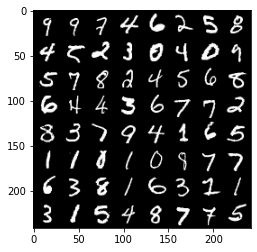

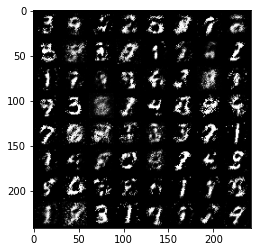

In [19]:


plt.imshow(np.transpose(make_grid(image_batch[0].to(device)[:images_to_diplay], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


plt.imshow(np.transpose(make_grid(G(fixed_noise).detach().cpu().reshape(batch_size,1,28,28)[:images_to_diplay], padding=2, normalize=True),(1,2,0)))

            # img_list.append(make_grid(fake, padding=2, normalize=True))

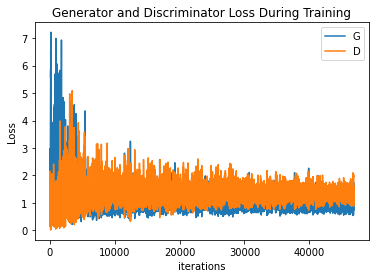

In [20]:
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
np.transpose(img_list[0],(1,2,0)).shape

torch.Size([242, 242, 3])

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML



fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[:images_to_diplay]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
ani.save('mnist_gan.mp4', writer=writer)

In [23]:
img_list[-1].shape

torch.Size([3, 242, 242])

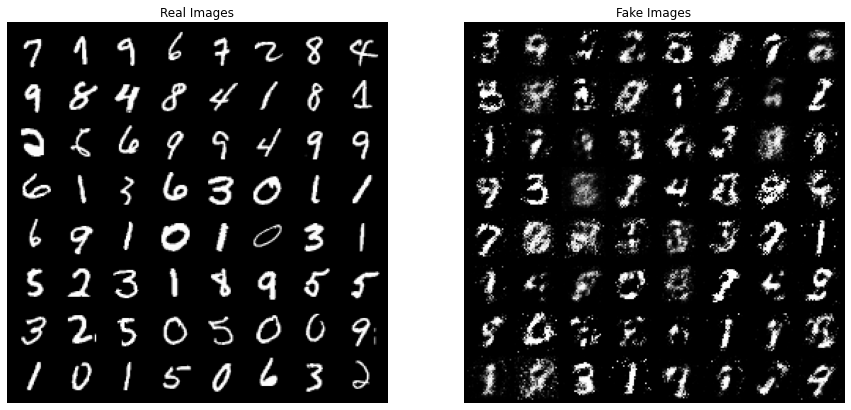

In [24]:
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:images_to_diplay], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
# plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()